# Fraiser Dialog Speaker Classification

### On a Raspberry Pi 3 (DietPi Buster image)

Data Source: https://www.kaggle.com/sulabhbista/frasier-dialogs/data#script.csv

Columns:
- url: URL from where the dialog was downloaded
- cast: Name of the cast
- dialog: Dialog utterance by the cast
- timestamp: Date/time when the a specific row was downloaded

Tasks:
- Explore the text data
  - E.g. Check the top words used by each speaker
- Balance classes, if applicable
- Tokenise the data and train a classifier to predict the speaker
 - Use pre-trained word embedding
 - Use own word embedding

In [89]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [90]:
df = pd.read_csv('./script.csv')
df.head()

,url,cast,dialog,timestamp
0,http://www.kacl780.net/frasier/transcripts/sea...,Frasier,"[firmly] Listen to yourself, Bob! You follow ...",2018-04-13 07:43:16
1,http://www.kacl780.net/frasier/transcripts/sea...,Roz,"Yes, Dr Crane. On line four, we have Russell ...",2018-04-13 07:43:16
2,http://www.kacl780.net/frasier/transcripts/sea...,Frasier,"[presses a button] Hello, Russell. This is Dr...",2018-04-13 07:43:16
3,http://www.kacl780.net/frasier/transcripts/sea...,Russell,"[v.o.] Well, I've been feeling sort of, uh, yo...",2018-04-13 07:43:16
4,http://www.kacl780.net/frasier/transcripts/sea...,Frasier,"Er, Russell, we're just about at the end of ou...",2018-04-13 07:43:16


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63945 entries, 0 to 63944
Data columns (total 4 columns):
url          63945 non-null object
cast         63943 non-null object
dialog       63788 non-null object
timestamp    63945 non-null object
dtypes: object(4)
memory usage: 999.2+ KB


In [92]:
# dropping some unneeded columns

df.drop(columns=['url', 'timestamp'], inplace=True)
df.head()

,cast,dialog
0,Frasier,"[firmly] Listen to yourself, Bob! You follow ..."
1,Roz,"Yes, Dr Crane. On line four, we have Russell ..."
2,Frasier,"[presses a button] Hello, Russell. This is Dr..."
3,Russell,"[v.o.] Well, I've been feeling sort of, uh, yo..."
4,Frasier,"Er, Russell, we're just about at the end of ou..."


In [93]:
# cleaning some NaN columns
df.dropna(inplace=True)

In [94]:
df['cast'].unique()

array(['Frasier', 'Roz', 'Russell', ...,
       'Rachel: You can do me one quick favor',
       'leaving is because I want what all of you have now', 'Pilot'],
      dtype=object)

In [95]:
# some cast values contain dialog, let's focus on cast with top 5 value_counts

main_cast_counts = df['cast'].value_counts()[:5]
main_cast_counts

Frasier    21088
Niles      10178
Martin      7629
Daphne      5243
Roz         4735
Name: cast, dtype: int64

In [96]:
df_main = df.loc[df['cast'].isin(main_cast_counts.keys())]
df_main.head()

,cast,dialog
0,Frasier,"[firmly] Listen to yourself, Bob! You follow ..."
1,Roz,"Yes, Dr Crane. On line four, we have Russell ..."
2,Frasier,"[presses a button] Hello, Russell. This is Dr..."
4,Frasier,"Er, Russell, we're just about at the end of ou..."
5,Roz,"No, we cut to the news thirty seconds ago."


## Data Exploration and Imbalance Checking

In [97]:
# There are 2x more Fraiser lines than the 2nd highest (Niles).
# Let's try to balance the dataset by sampling from the Fraiser rows
# Before we do that, let's see what the average dialog length is for Fraiser

In [98]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'[\w\']+') # include aposptophes

tokens = df_main.loc[df_main['cast'] == 'Frasier', 'dialog'].apply(tokenizer.tokenize)
tokens

0        [firmly, Listen, to, yourself, Bob, You, follo...
2        [presses, a, button, Hello, Russell, This, is,...
4        [Er, Russell, we're, just, about, at, the, end...
6        [annoyed, rips, off, his, headphones, Oh, for,...
7        [Well, the, rest, of, the, show, was, pretty, ...
9        [Roz, in, the, trade, we, call, that, avoidanc...
11       [I, am, not, a, piece, of, Lalique, I, can, ha...
13       [takes, the, notepaper, You, say, my, brother,...
17       [looks, up, Oh, I'm, sorry, Niles, I, didn't, ...
19       [Oh, Niles, you're, a, psychiatrist, you, know...
21                                                   [And]
23       [Yes, I, know, what, you, think, about, everyt...
26                            [Two, cafe, latte, supremos]
27                                        [No, thank, you]
29       [I'm, fine, I, love, my, new, life, I, love, t...
31       [So, does, he, laughs, The, fresh, air's, good...
33                                           [Is, it, Da

In [109]:
# remove stopwords
def tokenise_no_stopwords(text):
    stoplist = set(stopwords.words('english'))
    tokenizer = nltk.tokenize.RegexpTokenizer(r'[\w]+') # include aposptophes
    return [tok for tok in tokenizer.tokenize(text) if (tok.lower() not in stoplist)]

tokens = df_main.loc[df_main['cast'] == 'Frasier', 'dialog'].apply(tokenise_no_stopwords)
tokens

0        [firmly, Listen, Bob, follow, work, eavesdrop,...
2        [presses, button, Hello, Russell, Dr, Frasier,...
4        [Er, Russell, end, hour, Let, see, cut, chase,...
6        [annoyed, rips, headphones, Oh, crying, loud, ...
7        [Well, rest, show, pretty, good, Roz, says, no...
9        [Roz, trade, call, avoidance, change, subject,...
11              [piece, Lalique, handle, criticism, today]
13                [takes, notepaper, say, brother, called]
17       [looks, Oh, sorry, Niles, realise, stopped, ta...
19       [Oh, Niles, psychiatrist, know, like, listen, ...
21                                                      []
23       [Yes, know, think, everything, last, time, une...
26                            [Two, cafe, latte, supremos]
27                                                 [thank]
29       [fine, love, new, life, love, solitude, miss, ...
31                              [laughs, fresh, air, good]
33                                                   [Da

In [110]:
# plot wordcount distributions
def plot_wordcount_distribution(cast, df_input):
    tokens = df_input.loc[df_input['cast'] == cast, 'dialog'].apply(tokenise_no_stopwords)
    lengths = tokens.apply(len)
    sns.distplot(lengths, kde=False)
    plt.xlabel(cast)
    plt.show()
    return lengths.describe()

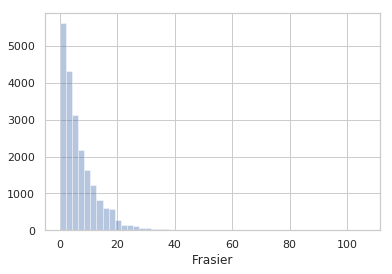

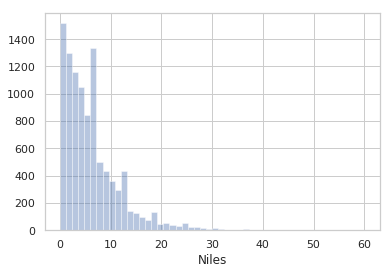

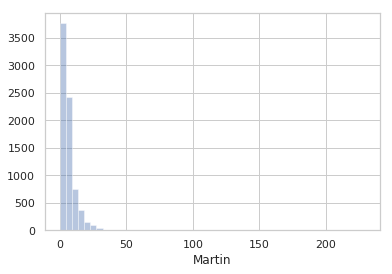

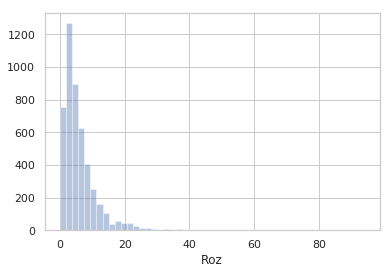

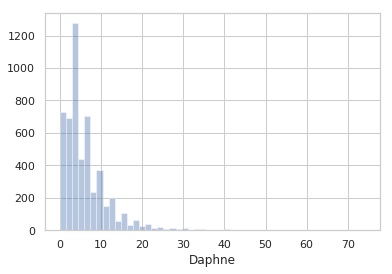

In [111]:
stats = pd.DataFrame({'Frasier': plot_wordcount_distribution('Frasier', df_main)})
stats = pd.concat([stats, pd.DataFrame({'Niles': plot_wordcount_distribution('Niles', df_main)})], axis=1) # col-wise concat
stats = pd.concat([stats, pd.DataFrame({'Martin': plot_wordcount_distribution('Martin', df_main)})], axis=1)
stats = pd.concat([stats, pd.DataFrame({'Roz': plot_wordcount_distribution('Roz', df_main)})], axis=1) 
stats = pd.concat([stats, pd.DataFrame({'Daphne': plot_wordcount_distribution('Daphne', df_main)})], axis=1)

In [112]:
# stats at a glance
stats

,Frasier,Niles,Martin,Roz,Daphne
count,21088.000000,10178.000000,7629.000000,4735.000000,5243.000000
mean,6.793484,6.218609,6.196618,5.760718,6.083349
std,6.559465,5.734493,6.491666,5.630727,5.980073
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,2.000000,2.000000,2.000000
50%,5.000000,5.000000,5.000000,4.000000,4.000000
75%,9.000000,8.000000,8.000000,8.000000,8.000000
max,106.000000,60.000000,229.000000,94.000000,74.000000


In [113]:
# 75% percentile is about 8-9 tokens
# The distributions are quite similar, so we will undersample from Frasier to balance the classes a bit more
# They don't have to be exactly the same.

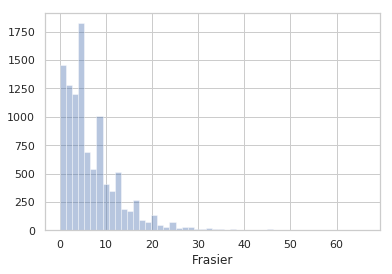

In [114]:
df_frasier_sampled = df_main.loc[df_main['cast'] == 'Frasier'].sample(frac=.5)

stats = pd.concat([stats, pd.DataFrame({'Frasier (sampled)': plot_wordcount_distribution('Frasier', df_frasier_sampled)})], axis=1)

In [115]:
# compare before and after undersampling.
stats

,Frasier,Niles,Martin,Roz,Daphne,Frasier (sampled)
count,21088.000000,10178.000000,7629.000000,4735.000000,5243.000000,10544.000000
mean,6.793484,6.218609,6.196618,5.760718,6.083349,6.835167
std,6.559465,5.734493,6.491666,5.630727,5.980073,6.437845
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,5.000000,5.000000,5.000000,4.000000,4.000000,5.000000
75%,9.000000,8.000000,8.000000,8.000000,8.000000,9.000000
max,106.000000,60.000000,229.000000,94.000000,74.000000,66.000000


In [116]:
# create our dataset
df_main_balanced = df_frasier_sampled

cast = ['Niles', 'Martin', 'Roz', 'Daphne']
for c in cast:
    df_main_balanced = pd.concat([df_main_balanced, 
                                  df_main.loc[df_main['cast'] == c]])

In [117]:
df_main_balanced['cast'].value_counts()

Frasier    10544
Niles      10178
Martin      7629
Daphne      5243
Roz         4735
Name: cast, dtype: int64

In [118]:
# save a snapshot of our balanced dataframe
pickle.dump(df_main_balanced, open('./df_main_balanced.pkl', 'wb'))

## Tokenisation

In [119]:
df_main_balanced = pickle.load(open('./df_main_balanced.pkl', 'rb'))
df_main_balanced.head()

,cast,dialog
46082,Frasier,"Well, whatever you have to tell yourself, Roz."
52653,Frasier,"Well of course it would. Niles, we've been th..."
8879,Frasier,Yes.
2957,Frasier,"Well let me see, I think I'll have the..."
8658,Frasier,"Denise, could you just hold on for a moment?"


In [120]:
def tokenise_no_stopwords_join(text):
    stoplist = set(stopwords.words('english'))
    tokenizer = nltk.tokenize.RegexpTokenizer(r'[\w]+') # include aposptophes
    return ' '.join([tok for tok in tokenizer.tokenize(text) if (tok.lower() not in stoplist)])

df_main_balanced['dialog_nostop'] = df_main_balanced['dialog'].apply(tokenise_no_stopwords_join)

In [121]:
df_main_balanced.head()

,cast,dialog,dialog_nostop
46082,Frasier,"Well, whatever you have to tell yourself, Roz.",Well whatever tell Roz
52653,Frasier,"Well of course it would. Niles, we've been th...",Well course would Niles last ten tortured year...
8879,Frasier,Yes.,Yes
2957,Frasier,"Well let me see, I think I'll have the...",Well let see think
8658,Frasier,"Denise, could you just hold on for a moment?",Denise could hold moment


In [122]:
# save a snapshot of our balanced dataframe without stopwords
pickle.dump(df_main_balanced, open('./df_main_balanced_nostop.pkl', 'wb'))

In [123]:
X = df_main_balanced['dialog_nostop']

le_y = LabelEncoder()
y = le_y.fit_transform(df_main_balanced['cast'])
y = tf.keras.utils.to_categorical(y)

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.1,
                                                    random_state=42)

In [134]:
# Tokenise, limiting to most frequent 5000 words
max_vocab_length = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_vocab_length, filters='')
tokenizer.fit_on_texts(X_train)

# Create sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)

# Set seq length near 75th percentile
seq_length = 11

# Pad sequences with pre-padding so that activations will be non-zero towards end of sequence
X_train_seq = tf.keras.preprocessing.sequence.pad_sequences(X_train_seq, maxlen=seq_length, 
                                                            padding='pre')
X_train_seq.shape, X_train_seq

((34496, 11), array([[   0,    0,  297, ...,   12, 2792,  223],
        [   0,    0,    0, ...,   89,  121,   55],
        [   0,    0,    0, ...,   41,    4,   28],
        ...,
        [   0,    0,    0, ...,  681, 2535, 1008],
        [   0,    0,    0, ...,    0, 3331,  104],
        [   0,    0,    0, ...,    0,    0,   21]]))

In [135]:
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq = tf.keras.preprocessing.sequence.pad_sequences(X_test_seq, maxlen=seq_length,
                                                           padding='pre')
X_test_seq.shape, X_test_seq

((3833, 11), array([[   0,    0,    0, ...,    0,    0,   34],
        [   2,   27, 1749, ...,   56,  106,  203],
        [   0,    0,    0, ...,   34,   93,  177],
        ...,
        [   0,    0,    0, ...,    1,   27, 3240],
        [   0,    0,    0, ...,    8,  332,    5],
        [   0,    0,    0, ...,   35,   43,  280]]))

In [160]:
len(tokenizer.index_word)

17875

## Model Engineering

- Simple 1D convolutional layer
- Simple GRU layer

In [165]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, Dense, Embedding, GlobalAvgPool1D, GRU
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import os, datetime

In [161]:
# Simple CNN model with non-pre-trained Embedding
cnn_simple = Sequential()
cnn_simple.add(Embedding(max_vocab_length+1, 50, input_length=seq_length))
cnn_simple.add(Conv1D(16, kernel_size=5, padding='same', activation='relu'))
cnn_simple.add(GlobalAvgPool1D())
cnn_simple.add(Dense(5, activation='softmax'))
cnn_simple.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 11, 50)            250050    
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 11, 16)            4016      
_________________________________________________________________
global_average_pooling1d_4 ( (None, 16)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 5)                 85        
Total params: 254,151
Trainable params: 254,151
Non-trainable params: 0
_________________________________________________________________


In [162]:
log_dir = os.path.join('./logs', 'fraiser', 'cnn_simple',
                                   datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tb = TensorBoard(log_dir=log_dir)
mc = ModelCheckpoint('fraiser_cnn_simple.h5', save_best_only=True, monitor='val_accuracy')

cnn_simple.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_simple.fit(X_train_seq, y_train, validation_split=.1,
                       batch_size=128, epochs=15, callbacks=[tb, mc])

Train on 31046 samples, validate on 3450 samples
Epoch 1/15
31046/31046 [==============================] - 43s 1ms/sample - loss: 1.5141 - accuracy: 0.3317 - val_loss: 1.4289 - val_accuracy: 0.3751
Epoch 2/15
31046/31046 [==============================] - 79s 3ms/sample - loss: 1.3282 - accuracy: 0.4410 - val_loss: 1.3582 - val_accuracy: 0.4220
Epoch 3/15
31046/31046 [==============================] - 18s 588us/sample - loss: 1.2220 - accuracy: 0.4992 - val_loss: 1.3578 - val_accuracy: 0.4325
Epoch 4/15
31046/31046 [==============================] - 18s 566us/sample - loss: 1.1519 - accuracy: 0.5312 - val_loss: 1.3691 - val_accuracy: 0.4348
Epoch 5/15
31046/31046 [==============================] - 18s 584us/sample - loss: 1.1017 - accuracy: 0.5518 - val_loss: 1.3932 - val_accuracy: 0.4258
Epoch 6/15
31046/31046 [==============================] - 17s 532us/sample - loss: 1.0678 - accuracy: 0.5663 - val_loss: 1.4221 - val_accuracy: 0.4290
Epoch 7/15
31046/31046 [=========================

In [163]:
best_model = load_model('fraiser_cnn_simple.h5')
best_model.evaluate(X_test_seq, y_test, verbose=0) # loss, accuracy

[1.3699064555505285, 0.4276024]

In [166]:
# Simple RNN model with non-pre-trained Embedding
rnn_simple = Sequential()
rnn_simple.add(Embedding(max_vocab_length+1, 50, input_length=seq_length))
rnn_simple.add(GRU(16))
rnn_simple.add(Dense(5, activation='softmax'))
rnn_simple.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 11, 50)            250050    
_________________________________________________________________
gru (GRU)                    (None, 16)                3264      
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 85        
Total params: 253,399
Trainable params: 253,399
Non-trainable params: 0
_________________________________________________________________


In [ ]:
log_dir = os.path.join('./logs', 'fraiser', 'rnn_simple',
                                   datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tb = TensorBoard(log_dir=log_dir)
mc = ModelCheckpoint('fraiser_rnn_simple.h5', save_best_only=True, monitor='val_accuracy')

rnn_simple.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
rnn_simple.fit(X_train_seq, y_train, validation_split=.1,
                       batch_size=128, epochs=15, callbacks=[tb, mc])

Train on 31046 samples, validate on 3450 samples
Epoch 1/15
  128/31046 [..............................] - ETA: 3:44:49 - loss: 1.6110 - accuracy: 0.2266

In [ ]:
best_model = load_model('fraiser_rnn_simple.h5')
best_model.evaluate(X_test_seq, y_test, verbose=0) # loss, accuracy